Ref: https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [2]:
data = pd.read_csv('../data/num_file/min_01/p040.csv')

In [3]:
print(data)

                   datetime  count
0       2022-04-21 01:40:00     23
1       2022-04-21 01:41:00    150
2       2022-04-21 01:42:00     27
3       2022-04-21 01:43:00      0
4       2022-04-21 01:44:00      0
...                     ...    ...
194995  2022-09-03 11:35:00    310
194996  2022-09-03 11:36:00    461
194997  2022-09-03 11:37:00    503
194998  2022-09-03 11:38:00    473
194999  2022-09-03 11:39:00    423

[195000 rows x 2 columns]


If there is no people, use NaN.

In [4]:
data.loc[data['count']==0, 'count'] = np.NaN

In [5]:
print(data)

                   datetime  count
0       2022-04-21 01:40:00   23.0
1       2022-04-21 01:41:00  150.0
2       2022-04-21 01:42:00   27.0
3       2022-04-21 01:43:00    NaN
4       2022-04-21 01:44:00    NaN
...                     ...    ...
194995  2022-09-03 11:35:00  310.0
194996  2022-09-03 11:36:00  461.0
194997  2022-09-03 11:37:00  503.0
194998  2022-09-03 11:38:00  473.0
194999  2022-09-03 11:39:00  423.0

[195000 rows x 2 columns]


<Axes: >

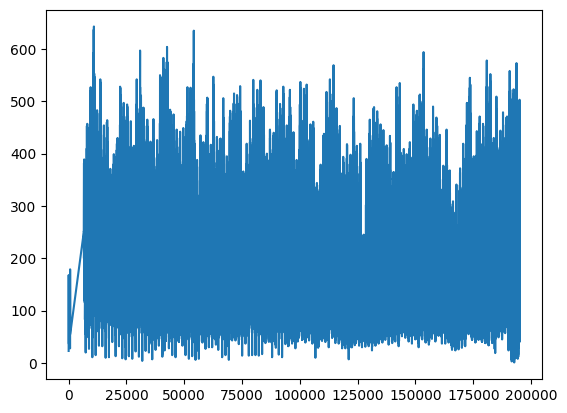

In [6]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

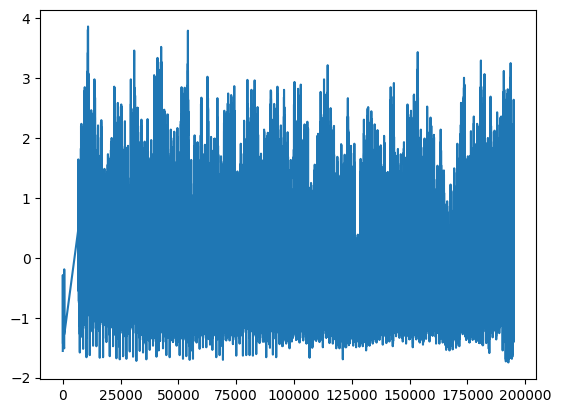

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [8]:
print(data)

                   datetime     count
0       2022-04-21 01:40:00 -1.554014
1       2022-04-21 01:41:00 -0.443766
2       2022-04-21 01:42:00 -1.519046
3       2022-04-21 01:43:00 -1.476925
4       2022-04-21 01:44:00 -1.434803
...                     ...       ...
194995  2022-09-03 11:35:00  0.954972
194996  2022-09-03 11:36:00  2.275031
194997  2022-09-03 11:37:00  2.642200
194998  2022-09-03 11:38:00  2.379936
194999  2022-09-03 11:39:00  1.942831

[195000 rows x 2 columns]


In [9]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 10

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [10]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [11]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

## Model

In [12]:
from keras.layers import Input, LSTM, BatchNormalization, RepeatVector, TimeDistributed, Dense, dot, multiply, concatenate, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [13]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [14]:
# encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, activation='relu', return_sequences=False, return_state=True)(input_train)
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(32, return_sequences=False, return_state=True)(input_train)

In [15]:
encoder_last_h1 = BatchNormalization()(encoder_last_h1)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [16]:
decoder = RepeatVector(time_step)(encoder_last_h1)
# decoder = LSTM(32, activation='relu', return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])
decoder = LSTM(32, return_state=False, return_sequences=True)(decoder, initial_state=[encoder_last_h1, encoder_last_c])

In [17]:
out = TimeDistributed(Dense(1))(decoder)

In [18]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 32),         4352        ['input_1[0][0]']                
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization (BatchNorm  (None, 32)          128         ['lstm[0][0]']                   
 alization)                                                                                   

In [19]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100
1097/1097 [==============================] - 7s 5ms/step - loss: 0.0422 - mae: 0.1399 - val_loss: 0.0437 - val_mae: 0.1519
Epoch 2/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0218 - mae: 0.1023 - val_loss: 0.0169 - val_mae: 0.0912
Epoch 3/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0132 - mae: 0.0788 - val_loss: 0.0108 - val_mae: 0.0687
Epoch 4/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0090 - mae: 0.0618 - val_loss: 0.0089 - val_mae: 0.0616
Epoch 5/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0075 - mae: 0.0536 - val_loss: 0.0072 - val_mae: 0.0510
Epoch 6/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0069 - mae: 0.0501 - val_loss: 0.0100 - val_mae: 0.0672
Epoch 7/100
1097/1097 [==============================] - 5s 5ms/step - loss: 0.0065 - mae: 0.0476 - val_loss: 0.0066 - val_mae: 0.0495
Epoch 8/100
1097/1097 [==============================] 

In [20]:
# model.save('./params/p040_seq2seq.keras')

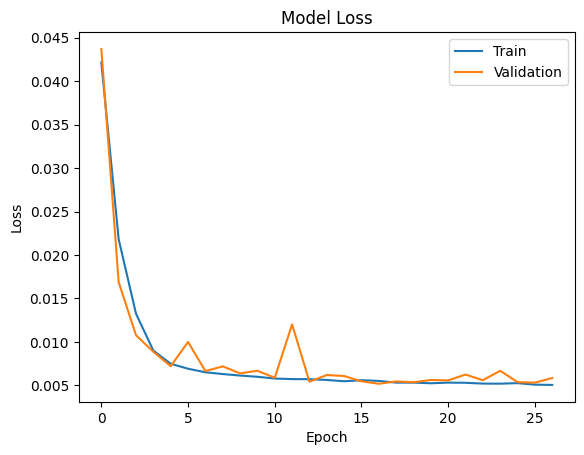

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [22]:
predict_train = model.predict(encode_input_data_train)

4875/4875 [==============================] - 8s 2ms/step


In [23]:
predict_test = model.predict(encode_input_data_test)

1219/1219 [==============================] - 2s 2ms/step


In [24]:
print(predict_train.shape)

(155991, 10, 1)


In [25]:
print(predict_test.shape)

(38998, 10, 1)


In [26]:
predict = np.concatenate([predict_train, predict_test], axis=0)
print(predict.shape)

(194989, 10, 1)


In [27]:
print(predict_test[:, -1, :])

[[-0.55376685]
 [-0.53004855]
 [-0.5209783 ]
 ...
 [ 1.4222617 ]
 [ 2.1356914 ]
 [ 2.2546098 ]]


In [28]:
print(decode_output_data_test[:, -1, :])

[[-0.63609232]
 [-0.53118698]
 [-0.33011841]
 ...
 [ 2.27503087]
 [ 2.64219956]
 [ 2.37993621]]


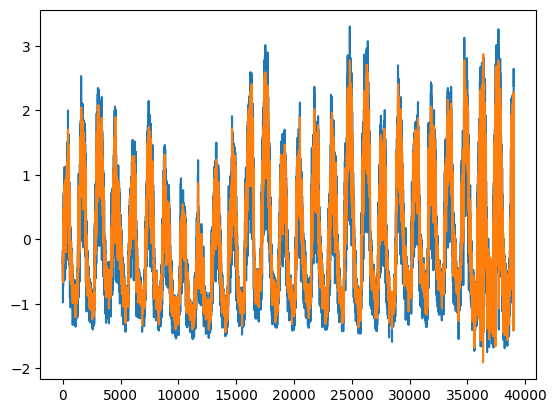

In [29]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

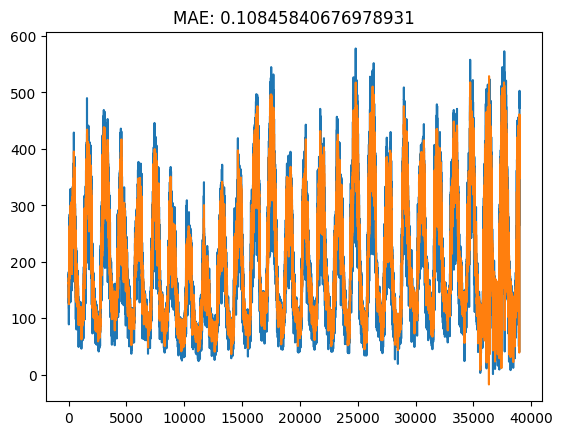

In [30]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)/decode_output_test_data))}')
plt.show()

## Attention

In [31]:
input_train = Input(shape=(time_step, 1))
output_train = Input(shape=(time_step, 1))

In [32]:
# encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, activation='relu', return_sequences=True, return_state=True)(input_train)
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(32, return_sequences=True, return_state=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 32), dtype=tf.float32, name=None), name='lstm_2/PartitionedCall:1', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm_2/PartitionedCall:2', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='lstm_2/PartitionedCall:3', description="created by layer 'lstm_2'")


In [33]:
encoder_last_h = BatchNormalization()(encoder_last_h)
encoder_last_c = BatchNormalization()(encoder_last_c)

In [34]:
decoder_input = RepeatVector(time_step)(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 32), dtype=tf.float32, name=None), name='repeat_vector_1/Tile:0', description="created by layer 'repeat_vector_1'")


In [35]:
# decoder_stack_h = LSTM(32, activation='relu', return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
decoder_stack_h = LSTM(32, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 32), dtype=tf.float32, name=None), name='lstm_3/PartitionedCall:1', description="created by layer 'lstm_3'")


In [36]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])

In [37]:
attention = Activation('softmax')(attention)

In [38]:
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 10), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


In [39]:
context = dot([attention, encoder_stack_h], axes=[2, 1])
context = BatchNormalization()(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 32), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")


In [40]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 64), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [41]:
out = TimeDistributed(Dense(1))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 1), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [42]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(learning_rate=0.01, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 10, 32),     4352        ['input_3[0][0]']                
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 32)          128         ['lstm_2[0][1]']                 
 rmalization)                                                                               

In [43]:
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100
1097/1097 [==============================] - 10s 8ms/step - loss: 0.0464 - mae: 0.1482 - val_loss: 0.0270 - val_mae: 0.1141
Epoch 2/100
1097/1097 [==============================] - 9s 8ms/step - loss: 0.0171 - mae: 0.0915 - val_loss: 0.0194 - val_mae: 0.1098
Epoch 3/100
1097/1097 [==============================] - 8s 7ms/step - loss: 0.0115 - mae: 0.0733 - val_loss: 0.0099 - val_mae: 0.0666
Epoch 4/100
1097/1097 [==============================] - 7s 7ms/step - loss: 0.0077 - mae: 0.0557 - val_loss: 0.0133 - val_mae: 0.0842
Epoch 5/100
1097/1097 [==============================] - 7s 7ms/step - loss: 0.0070 - mae: 0.0515 - val_loss: 0.0089 - val_mae: 0.0652
Epoch 6/100
1097/1097 [==============================] - 8s 7ms/step - loss: 0.0065 - mae: 0.0478 - val_loss: 0.0068 - val_mae: 0.0501
Epoch 7/100
1097/1097 [==============================] - 7s 7ms/step - loss: 0.0063 - mae: 0.0467 - val_loss: 0.0062 - val_mae: 0.0445
Epoch 8/100
1097/1097 [==============================]

In [44]:
# model.save('./params/p040_seq2seq_at.keras')

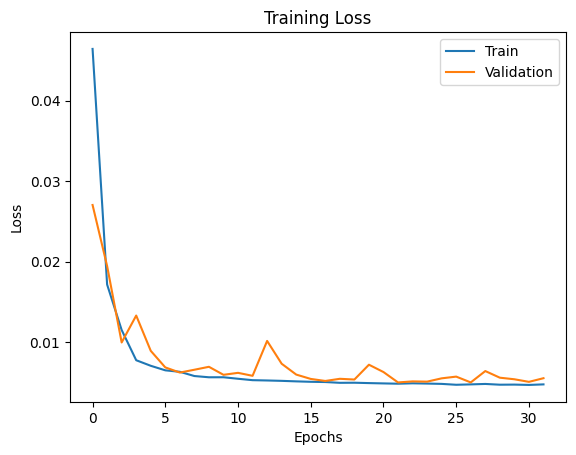

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [46]:
predict_test = model.predict(encode_input_data_test)

1219/1219 [==============================] - 2s 2ms/step


In [47]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

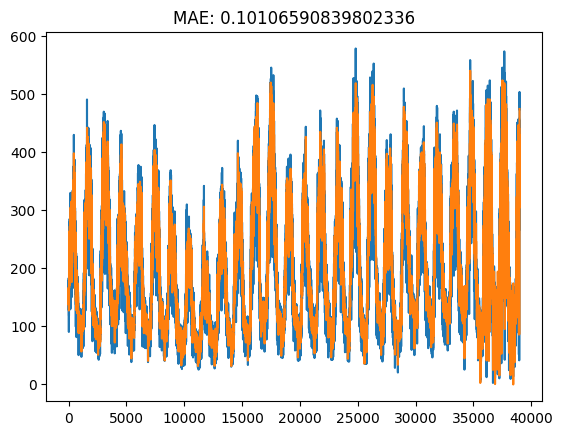

In [48]:
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)/decode_output_test_data))}')
plt.show()

In [49]:
print(predict_test_data)

[[136.60583]
 [135.5135 ]
 [136.47868]
 ...
 [375.63565]
 [455.02692]
 [473.6683 ]]


In [50]:
print(decode_output_test_data)

[[128.]
 [140.]
 [163.]
 ...
 [461.]
 [503.]
 [473.]]
